In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import ipaddress
import json

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from sklearn import decomposition
from sklearn.cluster import KMeans

from resources.firewall_rule import FirewallRule

In [6]:
# PCA Visualization

def dimensionality_reduce(dataset, n_components):
    """Reduce the input feature set to lower dimension space
    Args:
      dataset(Array): Input numpy array
      n_components(int): Number of dimensions to decompose

    Returns:
      principal_components: Dataset in reduced dimension space
    """
    principal_components = decomposition.PCA(n_components=n_components).fit_transform(dataset)
    return principal_components


def visualize_2d(dataset, cmap=None):
    """
    Visualize the low dimesional space image
    Args:
      dataset(array): 2 dimensional input dataset
      cmap(str): Colormap for visualization
    """
    assert (dataset.shape[1] == 2), "Dataset must have only 2 feature columns"
    plt.scatter(dataset[:, 0], dataset[:, 1], s=50, cmap=cmap)
    plt.xlabel('pca1')
    plt.ylabel('pca2')
    plt.show()


'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'1752190369480707101', u'data': u'{"allowed": [{"IPProtocol": "tcp"}], "creationTimestamp": "2017-07-19T12:28:50.295-07:00", "description": "", "direction": "INGRESS", "disabled": false, "id": "1752190369480707101", "kind": "compute#firewall", "name": "fw-tag-match", "network": "https://www.googleapis.com/compute/beta/projects/iap-1-174217/global/networks/default", "priority": 1000, "selfLink": "https://www.googleapis.com/compute/beta/projects/iap-1-174217/global/firewalls/fw-tag-match", "sourceTags": ["tag-match"], "targetTags": ["othertag", "sometag"]}', u'type_name': u'firewall/1752190369480707101', u'parent_type_name': u'project/iap-1-174217', u'full_name': u'organization/660570133860/project/iap-1-174217/firewall/1752190369480707101/', u'type': u'firewall', u'email': u''}
'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'8719472173724601402

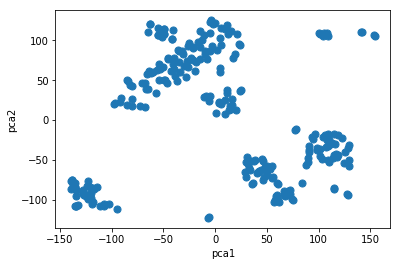

In [7]:
# Data processing / Feature engineering

# Approach #1, treats everything as categorical values

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
    """
    df = pd.DataFrame(resource_data_json)

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes
    df['org_id'] = df['org_id'].astype('category').cat.codes
    df['source_ip_addr'] = df['source_ip_addr'].astype('category').cat.codes
    df['dest_ip_addr'] = df['dest_ip_addr'].astype('category').cat.codes
    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes

    return df

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print(df_filtered.iloc[0])



pac_2 = dimensionality_reduce(df_filtered, 2)

visualize_2d(pac_2)

'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'1752190369480707101', u'data': u'{"allowed": [{"IPProtocol": "tcp"}], "creationTimestamp": "2017-07-19T12:28:50.295-07:00", "description": "", "direction": "INGRESS", "disabled": false, "id": "1752190369480707101", "kind": "compute#firewall", "name": "fw-tag-match", "network": "https://www.googleapis.com/compute/beta/projects/iap-1-174217/global/networks/default", "priority": 1000, "selfLink": "https://www.googleapis.com/compute/beta/projects/iap-1-174217/global/firewalls/fw-tag-match", "sourceTags": ["tag-match"], "targetTags": ["othertag", "sometag"]}', u'type_name': u'firewall/1752190369480707101', u'parent_type_name': u'project/iap-1-174217', u'full_name': u'organization/660570133860/project/iap-1-174217/firewall/1752190369480707101/', u'type': u'firewall', u'email': u''}
'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'8719472173724601402

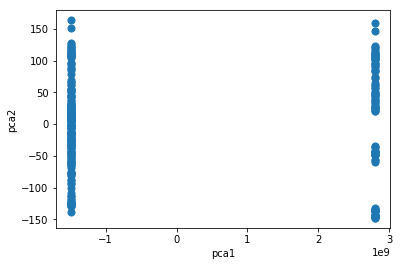

In [8]:
# Approach #2, penalized looser subnet exponentially

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
    """

    def subnet_count(ip_addr):
        """Covert ip address."""
        if ip_addr and '/' in ip_addr:
            _, subnet = ip_addr.split('/')
            return 2 ** (32 - int(subnet))
        return -1

    df = pd.DataFrame(resource_data_json)

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df['source_subnet_count'] = df['source_ip_addr'].apply(subnet_count)
    source_ips = df['source_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['source_ip_offset_1'] = source_ips[0] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_1'] = df['source_ip_offset_1'].astype('category').cat.codes
    df['source_ip_offset_2'] = source_ips[1] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_2'] = df['source_ip_offset_2'].astype('category').cat.codes
    df['source_ip_offset_3'] = source_ips[2] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_3'] = df['source_ip_offset_3'].astype('category').cat.codes
    df['source_ip_offset_4'] = source_ips[3] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_4'] = df['source_ip_offset_4'].astype('category').cat.codes

    df['dest_subnet_count'] = df['dest_ip_addr'].apply(subnet_count)
    dest_ips = df['dest_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['dest_ip_offset_1'] = dest_ips[0] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_1'] = df['dest_ip_offset_1'].astype('category').cat.codes
    df['dest_ip_offset_2'] = dest_ips[1] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_2'] = df['dest_ip_offset_2'].astype('category').cat.codes
    df['dest_ip_offset_3'] = dest_ips[2] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_3'] = df['dest_ip_offset_3'].astype('category').cat.codes
    df['dest_ip_offset_4'] = dest_ips[3] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_4'] = df['dest_ip_offset_4'].astype('category').cat.codes

    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes

    return df

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print(df_filtered.iloc[0])
    
pac_2 = dimensionality_reduce(df_filtered, 2)

visualize_2d(pac_2)

'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'1171673458620184650', u'data': u'{"allowed": [{"IPProtocol": "tcp", "ports": ["9300"]}, {"IPProtocol": "tcp", "ports": ["9200"]}], "creationTimestamp": "2018-08-01T21:20:53.997-07:00", "description": "", "direction": "INGRESS", "disabled": false, "id": "1171673458620184650", "kind": "compute#firewall", "name": "elasticsearch", "network": "https://www.googleapis.com/compute/v1/projects/boblee-sandbox/global/networks/default", "priority": 1000, "selfLink": "https://www.googleapis.com/compute/v1/projects/boblee-sandbox/global/firewalls/elasticsearch", "sourceTags": ["elasticsearch"], "targetTags": ["elasticsearch"]}', u'type_name': u'firewall/1171673458620184650', u'parent_type_name': u'project/boblee-sandbox', u'full_name': u'organization/986716781431/project/boblee-sandbox/firewall/1171673458620184650/', u'type': u'firewall', u'email': u''}
'NoneType' object is not iterable
{u'policy_update_

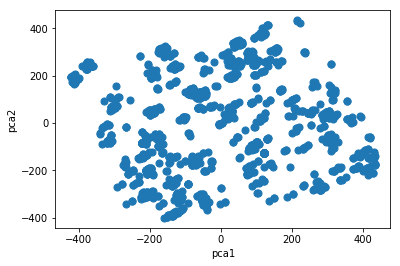

In [15]:
# Approach #3, penalized looser subnet with a multiple of 10

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
    """

    def subnet_count(ip_addr):
        """Covert ip address."""
        if ip_addr and '/' in ip_addr:
            _, subnet = ip_addr.split('/')
            return 10 * (32 - int(subnet))
        return -1

    df = pd.DataFrame(resource_data_json)

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df['source_subnet_count'] = df['source_ip_addr'].apply(subnet_count)
    source_ips = df['source_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['source_ip_offset_1'] = source_ips[0] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_1'] = df['source_ip_offset_1'].astype('category').cat.codes
    df['source_ip_offset_2'] = source_ips[1] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_2'] = df['source_ip_offset_2'].astype('category').cat.codes
    df['source_ip_offset_3'] = source_ips[2] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_3'] = df['source_ip_offset_3'].astype('category').cat.codes
    df['source_ip_offset_4'] = source_ips[3] if len(source_ips.columns) > 1 else ''
    df['source_ip_offset_4'] = df['source_ip_offset_4'].astype('category').cat.codes

    df['dest_subnet_count'] = df['dest_ip_addr'].apply(subnet_count)
    dest_ips = df['dest_ip_addr'].str.replace('/', '').str.split('.', expand = True)
    df['dest_ip_offset_1'] = dest_ips[0] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_1'] = df['dest_ip_offset_1'].astype('category').cat.codes
    df['dest_ip_offset_2'] = dest_ips[1] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_2'] = df['dest_ip_offset_2'].astype('category').cat.codes
    df['dest_ip_offset_3'] = dest_ips[2] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_3'] = df['dest_ip_offset_3'].astype('category').cat.codes
    df['dest_ip_offset_4'] = dest_ips[3] if len(dest_ips.columns) > 1 else ''
    df['dest_ip_offset_4'] = df['dest_ip_offset_4'].astype('category').cat.codes

    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes

    return df

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered = pre_process_firewall_data(
        flattened_firewall_rules_dict)
    print(df_filtered.iloc[0])
    
pac_2 = dimensionality_reduce(df_filtered, 2)

visualize_2d(pac_2)

'NoneType' object is not iterable
{u'policy_update_counter': 0, u'display_name': u'', u'name': u'1171673458620184650', u'data': u'{"allowed": [{"IPProtocol": "tcp", "ports": ["9300"]}, {"IPProtocol": "tcp", "ports": ["9200"]}], "creationTimestamp": "2018-08-01T21:20:53.997-07:00", "description": "", "direction": "INGRESS", "disabled": false, "id": "1171673458620184650", "kind": "compute#firewall", "name": "elasticsearch", "network": "https://www.googleapis.com/compute/v1/projects/boblee-sandbox/global/networks/default", "priority": 1000, "selfLink": "https://www.googleapis.com/compute/v1/projects/boblee-sandbox/global/firewalls/elasticsearch", "sourceTags": ["elasticsearch"], "targetTags": ["elasticsearch"]}', u'type_name': u'firewall/1171673458620184650', u'parent_type_name': u'project/boblee-sandbox', u'full_name': u'organization/986716781431/project/boblee-sandbox/firewall/1171673458620184650/', u'type': u'firewall', u'email': u''}
'NoneType' object is not iterable
{u'policy_update_

action                  0
creation_timestamp    683
direction               1
disabled                0
full_name             458
ip_protocol             0
network               103
ports                  19
service_account        -1
tag                    91
source_ip             119
source_ip_supernet    126
dest_ip                 2
dest_ip_supernet        2
Name: 0, dtype: int16


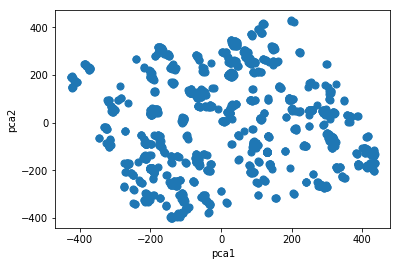

In [14]:
# Approach #4, using supernet as an additional feature and ignore the subnet.

def pre_process_firewall_data(resource_data_json):
    """Pre process resource data.

    Args:
        resource_data_json (list): A list of resource data in json format.
        selected_features (list): A list of selected features, if the
            list is empty, we will include all the features.

    Returns:
        DataFrame: DataFrame table with all the resource_data.
    """

    def ip_extraction(x):
        """Pre process ip data.
        Args:
            ip address (string): An ip address with subnet as a string.
        Returns:
            ip: IP extracted from the network.
            supernet: Supernet Ip network form the available ip network.
        """
        if not x:
            return '', ''
        l = []
        ip_add = ipaddress.IPv4Interface(x)
        ip_supernet = ipaddress.ip_network(x).supernet()
        return ip_add.ip, ip_supernet
    
    df = pd.DataFrame(resource_data_json)

    df['creation_timestamp'] = df['creation_timestamp'].astype('category').cat.codes
    df['direction'] = df['direction'].astype('category').cat.codes
    df['action'] = df['action'].astype('category').cat.codes
    df['disabled'] = df['disabled'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['ports'] = df['ports'].astype('category').cat.codes

    df[['source_ip','source_ip_supernet']] = df['source_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df[['dest_ip','dest_ip_supernet']] = df['dest_ip_addr'].apply(lambda x: pd.Series([ip_extraction(x)[0],ip_extraction(x)[1]]))
    df['source_ip'] = df['source_ip'].astype('category').cat.codes
    df['source_ip_supernet'] = df['source_ip_supernet'].astype('category').cat.codes
    df['dest_ip'] = df['dest_ip'].astype('category').cat.codes
    df['dest_ip_supernet'] = df['dest_ip_supernet'].astype('category').cat.codes
    df = df.drop(columns=['source_ip_addr', 'dest_ip_addr', 'org_id'])

    df['service_account'] = df['service_account'].astype('category').cat.codes
    df['tag'] = df['tag'].astype('category').cat.codes
    df['full_name'] = df['full_name'].astype('category').cat.codes
    df['ip_protocol'] = df['ip_protocol'].astype('category').cat.codes
    df['network'] = df['network'].astype('category').cat.codes

    return df

with open('sample_datasets/dataset_firewall.json') as firewall_dataset:
    firewall_rules = json.load(firewall_dataset)

    flattened_firewall_rules = FirewallRule.flatten_firewall_rules(firewall_rules)

    flattened_firewall_rules_dict = [i.to_dict() for i in flattened_firewall_rules]

    df_filtered = pre_process_firewall_data(flattened_firewall_rules_dict)
    print(df_filtered.iloc[0])
    
pac_2 = dimensionality_reduce(df_filtered, 2)

visualize_2d(pac_2)

In [4]:
# K means

def k_means(data, num_clusters, max_iter, seed=0):
    """Creates and fits the k-means model with dataset.

    Args:
       seed: Seed with which cluster centroids are
           initialized to track experiments
       data: Array/sparse-matrix each column representing a
           feature and row an instance
       num_clusters: Number of cluster and centroids to create
       max_iter: The maximum number of iterations for a single run

    Returns:
      kmeans: Model which has clustered the dataset
   """
    kmeans = KMeans(n_clusters=num_clusters, random_state=seed,
                    max_iter=max_iter).fit(data)
    return kmeans

m = k_means(df_filtered, 3, max_iter=100, seed=0)

In [ ]:
# Autoencoder
def autoencoder_model(input_shape):
    """
    The model function which computes the embedding.

    This is based on the implementation mentioned here:
    https://arxiv.org/pdf/1511.06335.pdf

    """
    input_layer = layers.Input(shape=input_shape)
    encoder_1 = layers.Dense(500, act='relu', name="encoder_1")(input_layer)
    encoder_2 = layers.Dense(500, act='relu', name="encoder_2")(encoder_1)
    encoder_3 = layers.Dense(2000, act='relu', name="encoder_3")(encoder_2)
    encoder_4 = layers.Dense(10, act='relu', name="encoder_4")(encoder_3)

    hidden = layers.Dense(10, act='relu', name="hidden")(encoder_4)

    decoder_1 = layers.Dense(10, act='relu', name="decoder_1")(hidden)
    decoder_2 = layers.Dense(2000, act='relu', name="decoder_2")(decoder_1)
    decoder_3 = layers.Dense(500, act='relu', name="decoder_3")(decoder_2)
    decoder_4 = layers.Dense(500, act='relu', name="decoder_4")(decoder_3)

    output_layer = layers.Dense(input_shape, name="output_layer")(decoder_4)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


def embedding_model(model):
    """Returns the Trained model which gives the embeddings as the output.

    Args:
        model: Trained autoencoder model

    Returns:
        intermediate model: Model split till the hidden layer

    """
    intermediate_model = model(
        inputs=[model.input],
        outputs=[model.get_layer("hidden").output])

    return intermediate_model